# Imports

In [19]:
import os
import sys

CWD = os.getcwd()

ROOT_DIR = os.path.abspath(os.path.join(CWD, ".."))
SRC_DIR = os.path.join(ROOT_DIR, "src")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.gini import gini
from src.utils.lorenz import lorenz_curve

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Load dataset

In [20]:
df = pd.read_csv("../data/processed/municipalities_connectivity_processed.csv")
df.head()

,year,state,state_name,municipality_id,municipality_name,ibc,coverage_4g5g,fibra,density_smp,hhi_smp,density_scm,hhi_scm,stations_density,region,fiber_cat,ibc_decile
0,2024,RO,Rondônia,1100296,Santa Luzia D'Oeste,49.92,62.9831,100,44.00,51,23.87,47,25.39,N,full,5
1,2024,AC,Acre,1200351,Marechal Thaumaturgo,16.28,30.3470,0,36.72,16,8.04,33,8.36,N,none,1
2,2024,AM,Amazonas,1300839,Caapiranga,29.17,50.9133,50,26.62,7,0.65,71,17.47,N,partial,1
3,2024,AM,Amazonas,1302207,Juruá,20.06,53.3310,0,36.33,36,5.85,19,13.45,N,none,1
4,2024,PA,Pará,1501204,Baião,34.08,52.8200,100,20.46,15,2.85,52,6.26,N,full,2


# Basic sanity check

In [21]:
df.describe(include="all")

,year,state,state_name,municipality_id,municipality_name,ibc,coverage_4g5g,fibra,density_smp,hhi_smp,density_scm,hhi_scm,stations_density,region,fiber_cat,ibc_decile
count,22280.000000,22280,22280,2.228000e+04,22280,22280.000000,22280.000000,22280.000000,22280.000000,22280.000000,22280.000000,22280.000000,22280.000000,22280,22280,22280.000000
unique,NaN,27,27,NaN,5297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,3,NaN
top,NaN,MG,Minas Gerais,NaN,São Domingos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NE,full,NaN
freq,NaN,3412,3412,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7176,16356,NaN
mean,2022.500000,NaN,NaN,3.253591e+06,NaN,51.906346,80.004675,76.216338,59.923873,47.390619,16.617638,56.186131,16.150221,NaN,NaN,5.500000
std,1.118059,NaN,NaN,9.848440e+05,NaN,13.865064,18.047806,40.896435,19.343919,25.059560,17.417516,20.941347,14.837588,NaN,NaN,2.872346
min,2021.000000,NaN,NaN,1.100015e+06,NaN,9.810000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.000000
25%,2021.750000,NaN,NaN,2.512101e+06,NaN,43.140000,68.548075,50.000000,46.220000,27.000000,3.850000,43.000000,6.700000,NaN,NaN,3.000000
50%,2022.500000,NaN,NaN,3.146280e+06,NaN,54.310000,84.711650,100.000000,60.180000,50.000000,11.490000,60.000000,11.240000,NaN,NaN,5.500000
75%,2023.250000,NaN,NaN,4.119202e+06,NaN,62.292500,95.494500,100.000000,74.562500,67.000000,23.330000,72.000000,20.050000,NaN,NaN,8.000000


# Compute Gini coefficients

In [22]:
variables = ["ibc", "coverage_4g5g", "density_scm", "density_smp"]

gini_values = {}

for var in variables:
    g = gini(df[var].dropna().values)
    gini_values[var] = g

gini_values

{'ibc': np.float64(0.15021688352742915),
 'coverage_4g5g': np.float64(0.12382614992188504),
 'density_scm': np.float64(0.5248806556210256),
 'density_smp': np.float64(0.18405382549392404)}

# Lorenz curve for density_scm

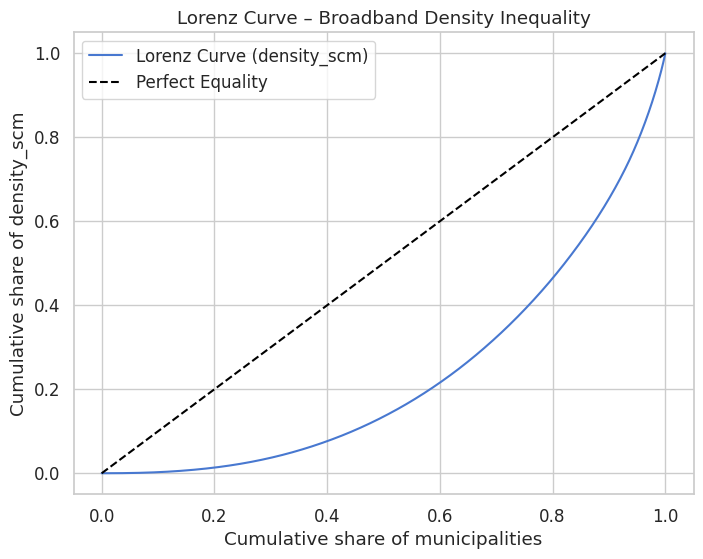

In [23]:
x = df["density_scm"].dropna().values
pop, lor = lorenz_curve(x)

plt.figure(figsize=(8,6))
plt.plot(pop, lor, label="Lorenz Curve (density_scm)")
plt.plot([0,1], [0,1], linestyle="--", color="black", label="Perfect Equality")
plt.xlabel("Cumulative share of municipalities")
plt.ylabel("Cumulative share of density_scm")
plt.title("Lorenz Curve – Broadband Density Inequality")
plt.legend()
plt.show()

# Gini by region

In [24]:
def gini_by_group(df, value_col, group_col):
    rows = []
    for group, subset in df.groupby(group_col):
        g = gini(subset[value_col].dropna().values)
        rows.append({group_col: group, "gini": g, "n": len(subset)})
    return pd.DataFrame(rows)

gini_region = gini_by_group(df, "density_scm", "region")
gini_region

,region,gini,n
0,CO,0.493256,1868
1,N,0.633509,1800
2,NE,0.561208,7176
3,S,0.406735,4764
4,SE,0.450616,6672


# Boxplot of IBC by Region

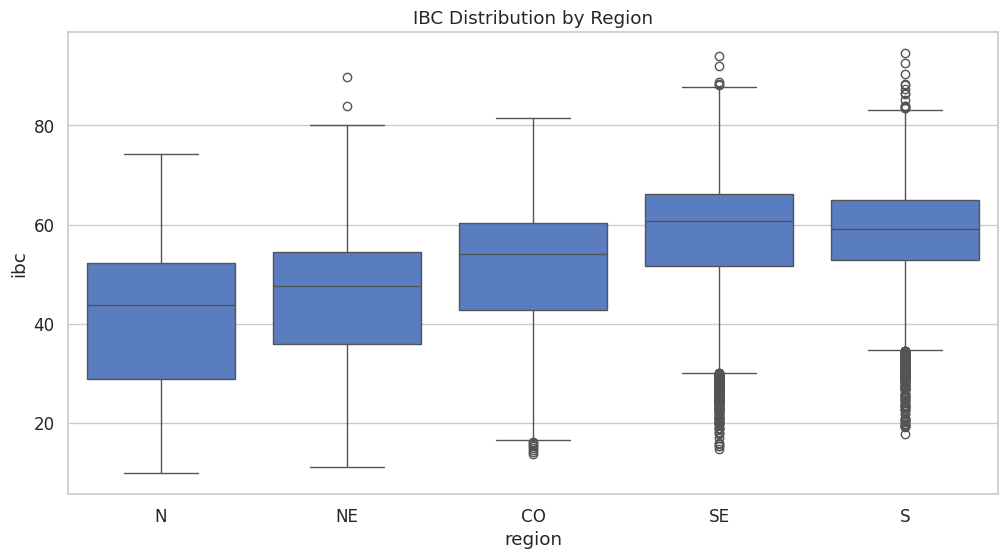

In [25]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="region", y="ibc", order=["N","NE","CO","SE","S"])
plt.title("IBC Distribution by Region")
plt.savefig("../reports/figures/boxplots/ibc_by_region.png", dpi=300)
plt.show()

# Compare IBC by fiber category

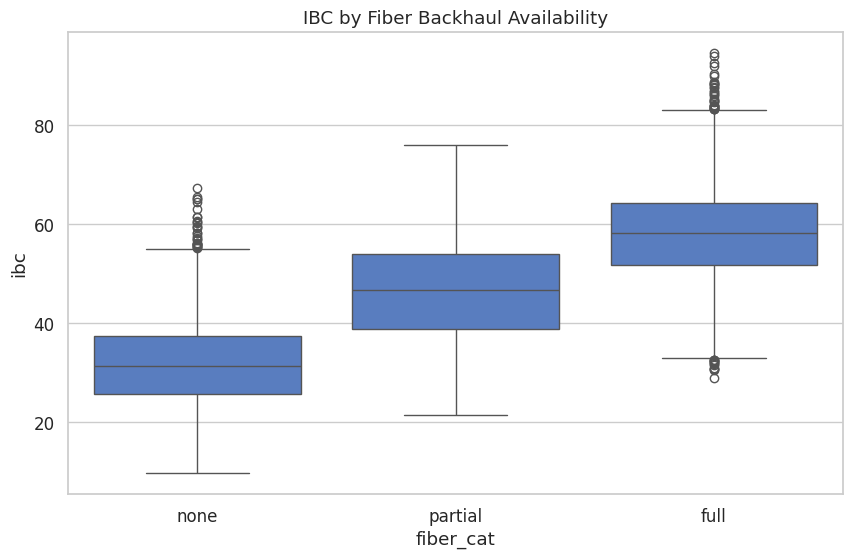

In [26]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="fiber_cat", y="ibc", order=["none","partial","full"])
plt.title("IBC by Fiber Backhaul Availability")
plt.savefig("../reports/figures/boxplots/ibc_by_fiber.png", dpi=300)
plt.show()

# Density_SCM vs HHI

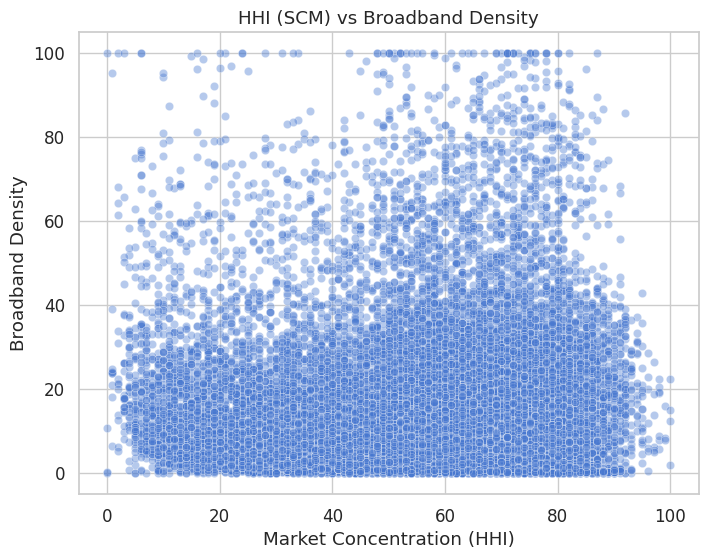

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="hhi_scm", y="density_scm", alpha=0.4)
plt.title("HHI (SCM) vs Broadband Density")
plt.xlabel("Market Concentration (HHI)")
plt.ylabel("Broadband Density")
plt.savefig("../reports/figures/inequality/hhi_vs_density.png", dpi=300)
plt.show()

# Long tail behavior

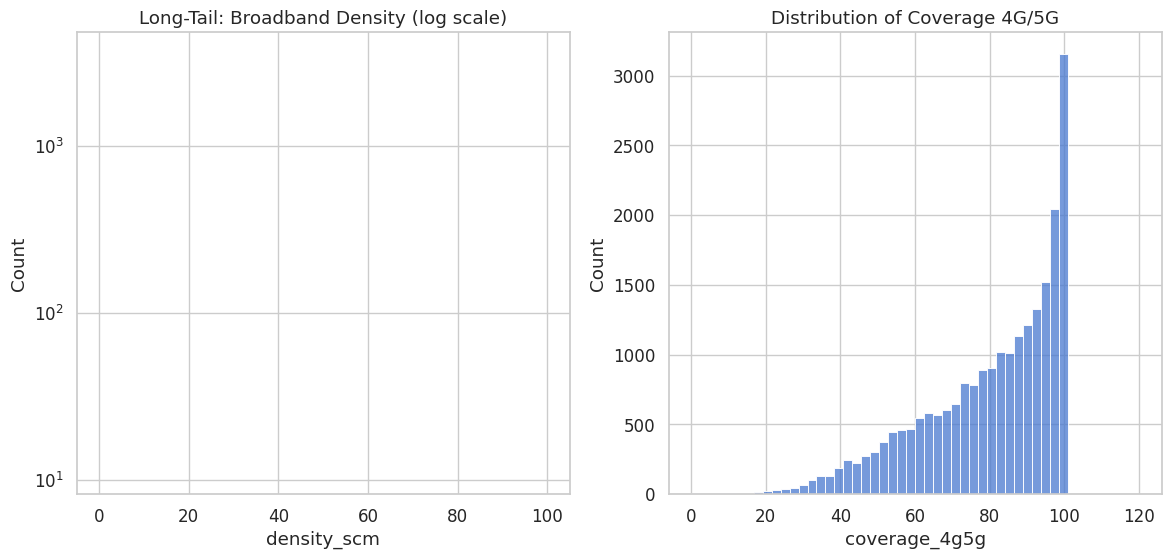

In [28]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

sns.histplot(df["density_scm"], bins=50, ax=ax[0], log_scale=(False, True))
ax[0].set_title("Long-Tail: Broadband Density (log scale)")

sns.histplot(df["coverage_4g5g"], bins=50, ax=ax[1], log_scale=(False, False))
ax[1].set_title("Distribution of Coverage 4G/5G")

plt.savefig("../reports/figures/inequality/long_tail.png", dpi=300)
plt.show()

# ANOVA: IBC ~ Region

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("ibc ~ C(region)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(region),8.985831e+05,4.0,1478.573838,0.0
Residual,3.384332e+06,22275.0,NaN,NaN


# Save Gini table

In [30]:
gini_region.to_csv("../reports/figures/inequality/gini_by_region.csv", index=False)